<a href="https://colab.research.google.com/github/stuckic/posCimatec/blob/main/Trabalho_5_Human_Activity_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho 5  
Equipe:   
*   Carlos Stucki  
*   Juliana Rappel
*   Reinaldo Góes  

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2
from xgboost import XGBClassifier
from collections import Counter
from time import time
import warnings
warnings.filterwarnings('ignore')

# Montar o Google Drive
drive.mount('/content/drive')

# Caminho do arquivo CSV no Google Drive
filepath = '/content/drive/MyDrive/Human_Activity_Recognition/Human_Activity_Recognition_Using_Smartphones_Data.csv'

# Ler os dados
data = pd.read_csv(filepath)

# Visualizar os primeiros registros
data.head()

class DataHandler:
    def __init__(self, data):
        self.data = data
        self.label_cols = self.data.columns
        self.clean_data()

    def clean_data(self):
       # Verificar a presença de duplicatas
      num_duplicatas = self.data.duplicated().sum()
      if num_duplicatas > 0:
        print(f"Encontradas {num_duplicatas} duplicatas.")
        # Remover duplicatas
        self.data.drop_duplicates(inplace=True)
      else:
        print("Nenhuma duplicata encontrada.")

    def show_data_info(self):
        return self.data.info()

    def show_describe(self):
        try:
            # Tenta descrever apenas as colunas numéricas
            description = self.data.select_dtypes(include=[np.number]).describe()
            print(description)
            # Boxplot para as primeiras 10 colunas
            self.data.iloc[:, :10].plot(kind='box', subplots=True, layout=(2, 5), figsize=(12, 6))
            plt.suptitle('Boxplots das Primeiras 10 Colunas')
            plt.show()

            # Histograma
            self.data['tBodyAcc-std()-X'].hist(bins=20)
            plt.title('Histograma de tBodyAcc-std()-X')
            plt.show()
        except Exception as e:
            # Imprime qualquer erro que ocorra
            print(f"Ocorreu um erro: {e}")

    def check_balance(self):
        print('Checando o balanceamento')
        label_column = self.data.iloc[:, -1]
        return label_column.value_counts()

    def check_outliers(self):
        # Selecionando apenas colunas numéricas
        numeric_cols = self.data.select_dtypes(include=[np.number])

        # Calculando o escore Z para cada valor em cada coluna
        z_scores = np.abs(stats.zscore(numeric_cols))

        # Verificando a presença de outliers
        outliers = (z_scores > 3)

        # Contando o número de outliers em cada coluna
        outliers_count = outliers.sum(axis=0)

        # Imprimindo o número de outliers em cada coluna
        for col, count in zip(numeric_cols.columns, outliers_count):
            print(f"{col}: {count} outliers")

        return outliers

    def get_duplicate_columns(self):

        duplicate_columns = {}
        seen_columns = {}

        for column in self.data.columns:
            current_column = self.data[column]

            # Converte as colinas para bytes
            try:
                current_column_hash = current_column.values.tobytes()
            except AttributeError:
                current_column_hash = current_column.to_string().encode()

            if current_column_hash in seen_columns:
                if seen_columns[current_column_hash] in duplicate_columns:
                    duplicate_columns[seen_columns[current_column_hash]].append(column)
                else:
                    duplicate_columns[seen_columns[current_column_hash]] = [column]
            else:
                seen_columns[current_column_hash] = column

        return duplicate_columns

    def remove_outliers(self):
        self.data = \
        self.data[(np.abs(stats.zscore(self.data.select_dtypes(include=[np.number])))\
           < 3).all(axis=1)]

    def remove_outliers(self, outliers):
        # Manter apenas as linhas que não são outliers (ou seja, onde todos os valores são False na matriz 'outliers')
        self.data = self.data[~outliers.any(axis=1)]

    def normalize(self):
        numeric_cols = self.data.select_dtypes(include=[np.number]).columns
        self.data[numeric_cols] = self.data[numeric_cols].apply(
            lambda x: (x - x.min()) / (x.max() - x.min())
        )

    def normalize_data(self, X):
        scaler = StandardScaler()
        return scaler.fit_transform(X)

    def apply_pca(self, X_normalized, variance=0.95):
        pca = PCA(variance)
        X_pca = pca.fit_transform(X_normalized)
        print(f"Número de componentes principais: {pca.n_components_}")
        return X_pca, pca

    def train_random_forest(self, X_pca, y):
        clf = RandomForestClassifier()
        clf.fit(X_pca, y)
        return clf

    def plot_feature_importances(self, clf, X_pca):
        importances = clf.feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.figure(figsize=(10, 6))
        plt.title('Importância dos Componentes Principais')
        plt.bar(range(X_pca.shape[1]), importances[indices], align='center')
        plt.xticks(range(X_pca.shape[1]), indices)
        plt.xlabel('Componentes Principais')
        plt.ylabel('Importância')
        plt.show()


    def perform_pca(self, n_components=2):
        numeric_cols = self.data.select_dtypes(include=[np.number]).columns
        pca = PCA(n_components=n_components)
        principal_components = pca.fit_transform(self.data[numeric_cols])
        pc_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components)])
        return pc_df, pca.explained_variance_ratio_

    def check_laterality(self, column_name):
        # Verifique a lateralidade baseada na coluna fornecida.
        laterality = {}
        for col in self.label_cols:
            laterality[col] = self.data[col].value_counts()
        return laterality

    def correlation_heatmap(self):
        plt.figure(figsize=(10, 8))
        sns.heatmap(self.data.corr(), cmap='coolwarm', center=0)
        plt.show()



Mounted at /content/drive


## Instancia  a Classe DataHandler

Nenhuma duplicata encontrada.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10299 entries, 0 to 10298
Columns: 541 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(540), object(1)
memory usage: 42.5+ MB
       tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
count       10299.000000       10299.000000       10299.000000   
mean            0.274347          -0.017743          -0.108925   
std             0.067628           0.037128           0.053033   
min            -1.000000          -1.000000          -1.000000   
25%             0.262625          -0.024902          -0.121019   
50%             0.277174          -0.017162          -0.108596   
75%             0.288354          -0.010625          -0.097589   
max             1.000000           1.000000           1.000000   

       tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
count      10299.000000      10299.000000      10299.000000      10299.000000   
mean          -0.607784       

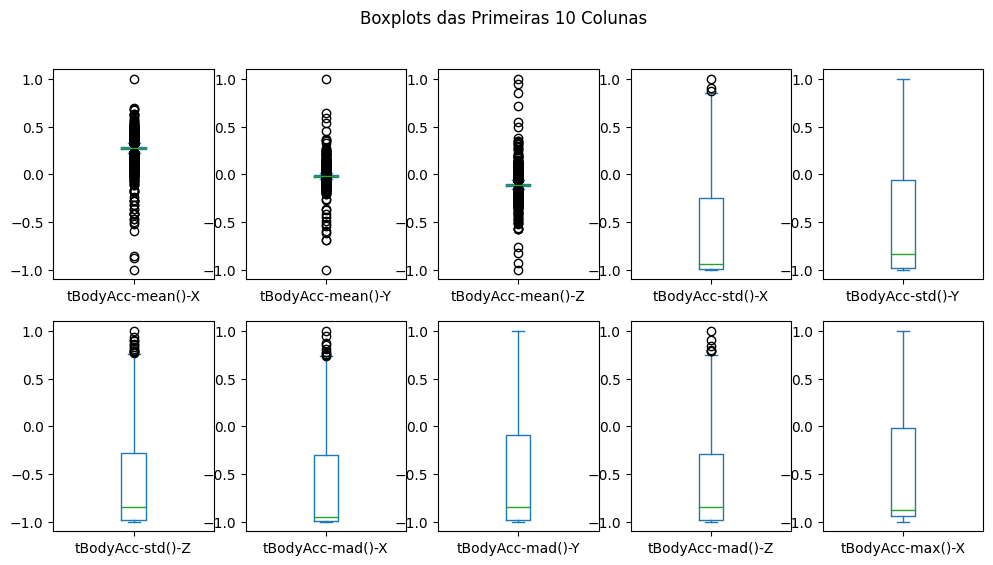

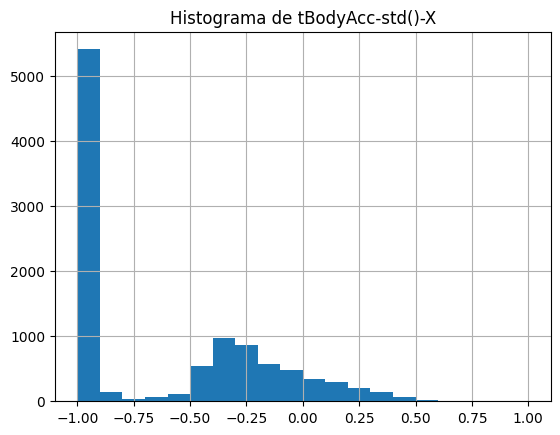

Checando o balanceamento
Número de componentes principais: 105


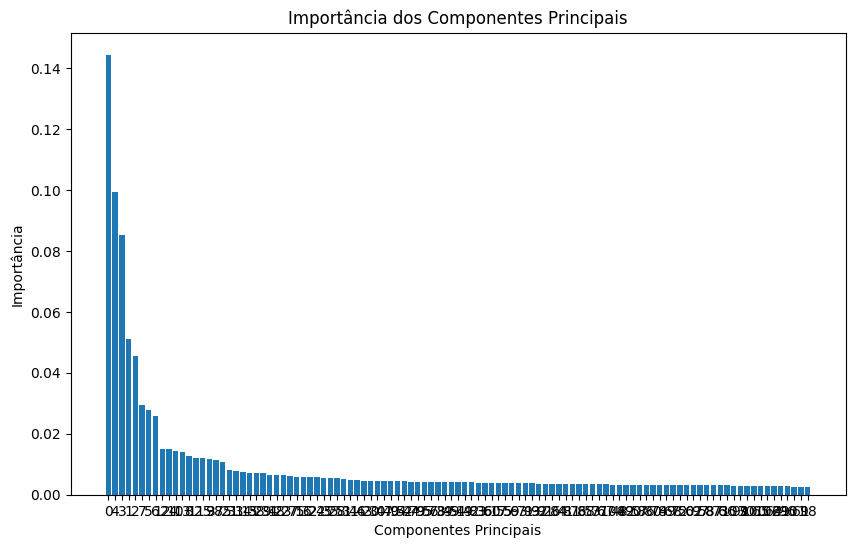

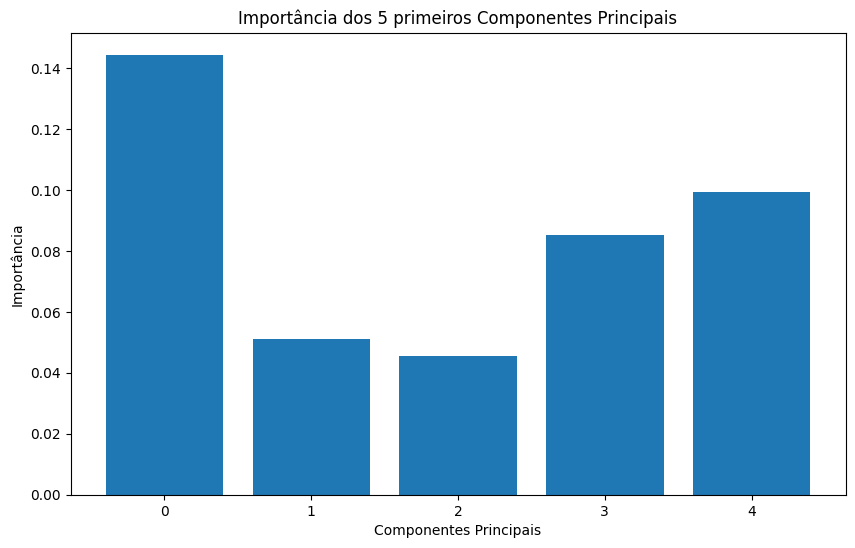

In [ ]:
dh = DataHandler(data)

duplicate_columns = dh.get_duplicate_columns()

for one_list in duplicate_columns.values():
   data.drop(columns=one_list,inplace=True)

dh.show_data_info()
dh.show_describe()
dh.check_balance()

X = data.drop(columns=["Activity"])
y = data["Activity"]

X_normalized = dh.normalize_data(X)
X_pca, pca = dh.apply_pca(X_normalized)
clf = dh.train_random_forest(X_pca, y)
dh.plot_feature_importances(clf, X_pca)

# Primeiro 5 importâncias
importances_5 = clf.feature_importances_[:5]

# Plotar as importâncias
plt.figure(figsize=(10, 6))
plt.title('Importância dos 5 primeiros Componentes Principais')
plt.bar(range(5), importances_5, align='center')
plt.xticks(range(5))
plt.xlabel('Componentes Principais')
plt.ylabel('Importância')
plt.show()

##Classe ModelHandler
Classe que chamas os modelos

In [ ]:
class ModelHandler:
    def __init__(self, X, y):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    def train_evaluate(self, model):
        start = time()
        model.fit(self.X_train, self.y_train)
        end = time()
        y_pred = model.predict(self.X_test)
        accuracy = accuracy_score(self.y_test, y_pred)
        training_time = end - start
        return accuracy, training_time

    def logistic_regression(self, params=None):
        if params is None:
            params = {
                'solver': 'lbfgs',
                'max_iter': 100
            }

        model = LogisticRegression(**params)
        return self.train_evaluate(model)

    def knn(self, params={}):
        if params is None:
            params = {
                'n_neighbors': 5
            }
        model = KNeighborsClassifier(**params)
        return self.train_evaluate(model)

    def mlp(self, params={}):
        if params is None:
            params = {
                'hidden_layer_sizes': (100,),
                'max_iter': 200,
                'activation': 'relu',
                'solver': 'adam'
            }
        model = MLPClassifier(**params)
        return self.train_evaluate(model)

    def svn(self, params={}):
        if params is None:
            params = {
                'kernel': 'rbf',
                'C': 1.0
            }
        model = SVC(**params)
        return self.train_evaluate(model)

    def bagging(self, params={}):
        if params is None:
            params = {
                'n_estimators': 10
            }
        model = BaggingClassifier(**params)
        return self.train_evaluate(model)

    def boosting(self, params={}):
        if params is None:
            params = {
                'n_estimators': 100,
                'learning_rate': 0.1
            }
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y)
        model = GradientBoostingClassifier(**params)
        return self.train_evaluate(model)

    def stacking(self):
        estimators = [
            ('lr', LogisticRegression(max_iter=1000)),
            ('knn', KNeighborsClassifier(n_neighbors=5)),
            ('mlp', MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000)),
            ('svm', SVC())
        ]
        model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
        return self.train_evaluate(model)

    def dimensionality_reduction(self, n_components=2):
        pca = PCA(n_components=n_components)
        self.X_train = pca.fit_transform(self.X_train)
        self.X_test = pca.transform(self.X_test)
        return self.X_train, self.X_test

    def train_evaluate_after_reduction(self, model, n_components=2):
        # Reduz a dimensionalidade dos dados
        pca = PCA(n_components=n_components)
        X_train_reduced = pca.fit_transform(self.X_train)
        X_test_reduced = pca.transform(self.X_test)

        # Treina o modelo com os dados reduzidos
        start = time()
        model.fit(X_train_reduced, self.y_train)
        end = time()

        # Faz previsões usando os dados de teste reduzidos
        y_pred = model.predict(X_test_reduced)

        # Calcula a precisão e o tempo de treinamento
        accuracy = accuracy_score(self.y_test, y_pred)
        training_time = end - start

        return accuracy, training_time

In [ ]:
# Agrupamento por parte dos nomes das colunas
pd.DataFrame.from_dict(Counter([col.split('-')[0].split('(')[0] for col in data.columns]),
                       orient='index').rename(columns={0:'count'}).sort_values('count', ascending=False)

,count
fBodyAcc,79
fBodyGyro,79
fBodyAccJerk,79
tGravityAcc,40
tBodyAcc,40
tBodyGyroJerk,40
tBodyGyro,40
tBodyAccJerk,40
tBodyAccMag,12
tBodyAccJerkMag,12


In [ ]:
## Totaliza valores nulos
data.isna().sum().sum()

0

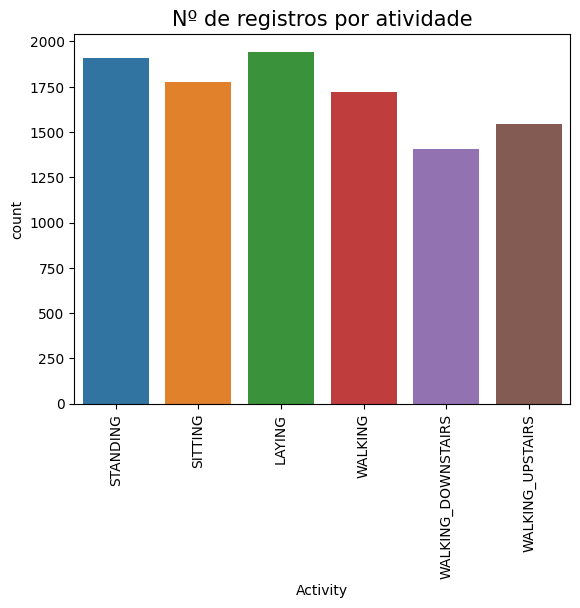

In [ ]:
## Quantidade de registros por atividade
plt.title('Nº de registros por atividade', fontsize=15)
sns.countplot(data=data, x='Activity')
plt.xticks(rotation=90)
plt.show()

##Execução padrão

In [ ]:
X = data.drop(columns=["Activity"])
y = data["Activity"]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

handler = ModelHandler(X, y_encoded)
acuracia, tempo_treinamento = handler.logistic_regression()
print(f"Regressão Logistica: Acurácia = {acuracia:.2f}, Tempo = {tempo_treinamento:.2f}s")

acuracia, training_time = handler.knn()
print(f"KNN: Acurácia = {acuracia:.2f}, Tempo = {tempo_treinamento:.2f}s")

acuracia, tempo_treinamento = handler.mlp()
print(f"MLP: Acurácia = {acuracia:.2f}, Tempo = {tempo_treinamento:.2f}s")

accuracy, tempo_treinamento = handler.svn()
print(f"SVN: Acurácia = {accuracy:.2f}, Tempo = {tempo_treinamento:.2f}s")

acuracia, tempo_treinamento = handler.bagging()
print(f"BAGGING: Acurácia = {acuracia:.2f}, Tempo = {tempo_treinamento:.2f}s")

handler = ModelHandler(X, y)
acuracia, tempo_treinamento = handler.stacking()
print(f"STACKING: Acurácia = {acuracia:.2f}, Tempo = {tempo_treinamento:.2f}s")

handler = ModelHandler(X, y_encoded)
acuracia, tempo_treinamento = handler.boosting()
print(f"BOOSTING: Acurácia = {acuracia:.2f}, Tempo = {tempo_treinamento:.2f}s")

Regressão Logistica: Acurácia = 0.98, Tempo = 3.68s
KNN: Acurácia = 0.96, Tempo = 3.68s
MLP: Acurácia = 0.98, Tempo = 55.41s
SVN: Acurácia = 0.97, Tempo = 2.68s
BAGGING: Acurácia = 0.96, Tempo = 51.17s
STACKING: Acurácia = 0.99, Tempo = 416.76s
BOOSTING: Acurácia = 0.99, Tempo = 1110.28s


## Treinamento dos modelos com redução da dimensionalidade

In [ ]:
# Redução de dimensionalidade para 20 dimensões usando SelectKBest
X = data.drop(columns=["Activity"])
y = data["Activity"]

# Crie um scaler para dimensionar as características para o intervalo [0, 1]
scaler = MinMaxScaler()

# Ajuste e transforme os dados usando o scaler
X_scaled = scaler.fit_transform(X)

# Use o SelectKBest com chi2 nos dados escalados
X_reduzido = SelectKBest(chi2, k=20).fit_transform(X_scaled, y)

# Verifique a forma do conjunto de dados reduzido
print(X_reduzido.shape)

handler = ModelHandler(X_reduzido, y_encoded)
acuracia, tempo_treinamento = handler.logistic_regression()
print(f"Regressão Logistica: Acurácia = {acuracia:.2f}, Tempo = {tempo_treinamento:.2f}s")

acuracia, training_time = handler.knn()
print(f"KNN: Acurácia = {acuracia:.2f}, Tempo = {tempo_treinamento:.2f}s")

acuracia, tempo_treinamento = handler.mlp()
print(f"MLP: Acurácia = {acuracia:.2f}, Tempo = {tempo_treinamento:.2f}s")

accuracy, tempo_treinamento = handler.svn()
print(f"SVN: Acurácia = {accuracy:.2f}, Tempo = {tempo_treinamento:.2f}s")

acuracia, tempo_treinamento = handler.bagging()
print(f"BAGGING: Acurácia = {acuracia:.2f}, Tempo = {tempo_treinamento:.2f}s")

handler = ModelHandler(X, y)
acuracia, tempo_treinamento = handler.stacking()
print(f"STACKING: Acurácia = {acuracia:.2f}, Tempo = {tempo_treinamento:.2f}s")

handler = ModelHandler(X, y_encoded)
acuracia, tempo_treinamento = handler.boosting()
print(f"BOOSTING: Acurácia = {acuracia:.2f}, Tempo = {tempo_treinamento:.2f}s")

(10299, 20)
Regressão Logistica: Acurácia = 0.83, Tempo = 0.79s
KNN: Acurácia = 0.88, Tempo = 0.79s
MLP: Acurácia = 0.87, Tempo = 12.17s
SVN: Acurácia = 0.83, Tempo = 1.23s
BAGGING: Acurácia = 0.91, Tempo = 1.18s
STACKING: Acurácia = 0.99, Tempo = 429.94s
BOOSTING: Acurácia = 0.99, Tempo = 1094.61s


In [ ]:
# Redução de dimensionalidade usando PCA
def train_and_evaluate_models(X, y, n_components=None):
    if n_components:
        handler = ModelHandler(X, y)
        handler.dimensionality_reduction(n_components=n_components)
    else:
        handler = ModelHandler(X, y)

    results = {}
    models = ['logistic_regression', 'knn', 'mlp', 'svn', 'bagging', 'boosting', 'stacking']
    for model_name in models:
        model_function = getattr(handler, model_name)
        accuracy, training_time = model_function()
        results[model_name] = {
            'accuracy': accuracy,
            'training_time': training_time
        }
    return results

# Treinando com todas as 105 componentes:
results_105 = train_and_evaluate_models(X_pca, y)

# Treinando com as 5 principais componentes:
results_5 = train_and_evaluate_models(X_pca, y, n_components=5)

print("Resultados usando 105 componentes:")
for model, res in results_105.items():
    print(f"Modelo: {model}, Precisão: {res['accuracy']}, Tempo de treino: {res['training_time']}s")

print("\nResultados usando 5 componentes:")
for model, res in results_5.items():
    print(f"Modelo: {model}, Precisão: {res['accuracy']}, Tempo de treino: {res['training_time']}s")


Resultados usando 105 componentes:
Modelo: logistic_regression, Precisão: 0.9713592233009709, Tempo de treino: 0.8253984451293945s
Modelo: knn, Precisão: 0.954368932038835, Tempo de treino: 0.021411895751953125s
Modelo: mlp, Precisão: 0.9781553398058253, Tempo de treino: 8.662985563278198s
Modelo: svn, Precisão: 0.9684466019417476, Tempo de treino: 1.3140921592712402s
Modelo: bagging, Precisão: 0.8980582524271845, Tempo de treino: 9.624340772628784s
Modelo: boosting, Precisão: 0.9446601941747573, Tempo de treino: 238.64269828796387s
Modelo: stacking, Precisão: 0.9791262135922331, Tempo de treino: 93.47523498535156s

Resultados usando 5 componentes:
Modelo: logistic_regression, Precisão: 0.8058252427184466, Tempo de treino: 0.2974576950073242s
Modelo: knn, Precisão: 0.8029126213592233, Tempo de treino: 0.017795801162719727s
Modelo: mlp, Precisão: 0.8242718446601942, Tempo de treino: 6.029535293579102s
Modelo: svn, Precisão: 0.8135922330097087, Tempo de treino: 0.6635420322418213s
Modelo

##Ajuste de Parametros

In [ ]:
X = data.drop(columns=["Activity"])
y = data["Activity"]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
handler = ModelHandler(X, y_encoded)

print('Ajuste de Parametos')
#Regressão Logistica
params_RL = {'max_iter': 1000, 'solver': 'liblinear','penalty': 'l2', 'C': 100}
acuracia, tempo_treinamento = handler.logistic_regression(params_RL)
print(f"Regressão Logistica: Acurácia = {acuracia:.2f}, Tempo = {tempo_treinamento:.2f}s")

#KNN
params_KNN = {'n_neighbors': 15, 'weights': 'distance','algorithm': 'auto', 'p': 2}
acuracia, training_time = handler.knn(params_KNN)
print(f"KNN: Acurácia = {acuracia:.2f}, Tempo = {tempo_treinamento:.2f}s")

#MLP
params_MLP = {'hidden_layer_sizes': [50,25], 'activation': 'relu','solver': 'adam', 'alpha': 0.0001,'max_iter': 1000 }
acuracia, tempo_treinamento = handler.mlp(params_MLP)
print(f"MLP: Acurácia = {acuracia:.2f}, Tempo = {tempo_treinamento:.2f}s")

#SVN
params_SVN = {'C':10, 'kernel':'rbf','gamma':0.1, 'degree':3, 'coef0':0 }
accuracy, tempo_treinamento = handler.svn(params_SVN)
print(f"SVN: Acurácia = {accuracy:.2f}, Tempo = {tempo_treinamento:.2f}s")

#BAGGING
params_bag = {'estimator':DecisionTreeClassifier(), 'n_estimators':100,'max_samples':0.8, 'max_features':0.5 }
acuracia, tempo_treinamento = handler.bagging(params_bag)
print(f"BAGGING: Acurácia = {acuracia:.2f}, Tempo = {tempo_treinamento:.2f}s")

#BOOSTING
params_boo = {'loss':'deviance', 'learning_rate':0.1,'n_estimators':100, 'subsample':0.8, 'max_depth':3 }
acuracia, tempo_treinamento = handler.boosting(params_boo)
print(f"BOOSTING: Acurácia = {acuracia:.2f}, Tempo = {tempo_treinamento:.2f}s")

Ajuste de Parametos
Regressão Logistica: Acurácia = 0.98, Tempo = 21.33s
KNN: Acurácia = 0.96, Tempo = 21.33s
MLP: Acurácia = 0.99, Tempo = 40.28s
SVN: Acurácia = 0.99, Tempo = 11.76s
BAGGING: Acurácia = 0.97, Tempo = 211.77s
BOOSTING: Acurácia = 0.99, Tempo = 862.59s


## Tabela de Comparação

<table border="1">
    <thead>
        <tr>
            <th>Nome do Método</th>
            <th>Parâmetros</th>
            <th>Acurácia</th>
            <th>Tempo</th>
        </tr>
    </thead>
    <tbody>
        <!-- Dados originais -->
        <tr>
            <td>Regressão Logística</td>
            <td>Padrão</td>
            <td>0.98</td>
            <td>4.62s</td>
        </tr>
        <tr>
            <td>Regressão Logística</td>
            <td>Padrão</td>
            <td>0.98</td>
            <td>3.68s</td>
        </tr>
        <tr>
            <td>KNN</td>
            <td>Padrão</td>
            <td>0.96</td>
            <td>3.68s</td>
        </tr>
        <tr>
            <td>MLP</td>
            <td>Padrão</td>
            <td>0.98</td>
            <td>55.41s</td>
        </tr>
        <tr>
            <td>SVN</td>
            <td>Padrão</td>
            <td>0.97</td>
            <td>2.68s</td>
        </tr>
        <tr>
            <td>BAGGING</td>
            <td>Padrão</td>
            <td>0.96</td>
            <td>51.17s</td>
        </tr>
        <tr>
            <td>STACKING</td>
            <td>Padrão</td>
            <td>0.99</td>
            <td>416.76s</td>
        </tr>
        <tr>
            <td>BOOSTING</td>
            <td>Padrão</td>
            <td>0.99</td>
            <td>1110.28s</td>
        </tr>
        <!-- Dados com redução de dimensionalidade -->
        <tr>
            <td>Regressão Logística</td>
            <td>20 Componentes</td>
            <td>0.83</td>
            <td>0.79s</td>
        </tr>
        <tr>
            <td>KNN</td>
            <td>20 Componentes</td>
            <td>0.88</td>
            <td>0.79s</td>
        </tr>
        <tr>
            <td>MLP</td>
            <td>20 Componentes</td>
            <td>0.87</td>
            <td>12.17s</td>
        </tr>
        <tr>
            <td>SVN</td>
            <td>20 Componentes</td>
            <td>0.83</td>
            <td>1.23s</td>
        </tr>
        <tr>
            <td>BAGGING</td>
            <td>20 Componentes</td>
            <td>0.91</td>
            <td>1.18s</td>
        </tr>
        <tr>
            <td>STACKING</td>
            <td>20 Componentes</td>
            <td>0.99</td>
            <td>429.94s</td>
        </tr>
        <tr>
            <td>BOOSTING</td>
            <td>20 Componentes</td>
            <td>0.99</td>
            <td>1094.61s</td>
        </tr>
        <!-- Dados com redução de dimensionalidade -->
        <tr>
            <td>Regressão Logística</td>
            <td>Redução de dimensionalidade(Remoção das colunas duplicadas)</td>
            <td>0.98</td>
            <td>2.40s</td>
        </tr>
        <tr>
            <td>KNN</td>
            <td>Redução de dimensionalidade(Remoção das colunas duplicadas)</td>
            <td>0.96</td>
            <td>2.40s</td>
        </tr>
        <tr>
            <td>MLP</td>
            <td>Redução de dimensionalidade(Remoção das colunas duplicadas)</td>
            <td>0.99</td>
            <td>28.32s</td>
        </tr>
        <tr>
            <td>SVN</td>
            <td>Redução de dimensionalidade(Remoção das colunas duplicadas)</td>
            <td>0.97</td>
            <td>1.29s</td>
        </tr>
        <tr>
            <td>BAGGING</td>
            <td>Redução de dimensionalidade(Remoção das colunas duplicadas)</td>
            <td>0.96</td>
            <td>39.23s</td>
        </tr>
        <tr>
            <td>STACKING</td>
            <td>Redução de dimensionalidade(Remoção das colunas duplicadas)</td>
            <td>0.99</td>
            <td>197.21s</td>
        </tr>
        <!-- E assim por diante para os outros métodos -->
        <!-- ... -->
        <!-- Resultados usando 105 componentes -->
        <tr>
            <td>Regressão Logística</td>
            <td>105 Componentes</td>
            <td>0.9713592233009709</td>
            <td>0.8253984451293945s</td>
        </tr>
        <tr>
            <td>KNN</td>
            <td>105 Componentes</td>
            <td>0.954368932038835</td>
            <td>0.021411895751953125s</td>
        </tr>
        <tr>
            <td>MLP</td>
            <td>105 Componentes</td>
            <td>0.9781553398058253</td>
            <td>8.662985563278198s</td>
        </tr>
        <tr>
            <td>SVN</td>
            <td>105 Componentes</td>
            <td>0.9684466019417476</td>
            <td>1.3140921592712402s</td>
        </tr>
        <tr>
            <td>BAGGING</td>
            <td>105 Componentes</td>
            <td>0.8980582524271845</td>
            <td>9.624340772628784s</td>
        </tr>
        <tr>
            <td>BOOSTING</td>
            <td>105 Componentes</td>
            <td>0.9446601941747573</td>
            <td>238.64269828796387s</td>
        </tr>
        <tr>
            <td>STACKING</td>
            <td>105 Componentes</td>
            <td>0.9791262135922331</td>
            <td>93.47523498535156s</td>
        </tr>
        <!-- Resultados usando 5 componentes -->
        <tr>
            <td>Regressão Logística</td>
            <td>5 Componentes</td>
            <td>0.8058252427184466</td>
            <td>0.2974576950073242s</td>
        </tr>
        <tr>
            <td>KNN</td>
            <td>5 Componentes</td>
            <td>0.8029126213592233</td>
            <td>0.017795801162719727s</td>
        </tr>
        <tr>
            <td>MLP</td>
            <td>5 Componentes</td>
            <td>0.8242718446601942</td>
            <td>6.029535293579102s</td>
        </tr>
        <tr>
            <td>SVN</td>
            <td>5 Componentes</td>
            <td>0.8135922330097087</td>
            <td>0.6635420322418213s</td>
        </tr>
        <tr>
            <td>BAGGING</td>
            <td>5 Componentes</td>
            <td>0.7970873786407767</td>
            <td>0.39666128158569336s</td>
        </tr>
        <tr>
            <td>BOOSTING</td>
            <td>5 Componentes</td>
            <td>0.8092233009708738</td>
            <td>15.08488154411316s</td>
        </tr>
        <tr>
            <td>STACKING</td>
            <td>5 Componentes</td>
            <td>0.8368932038834952</td>
            <td>141.21419882774353s</td>
        </tr>
       <tr>
          <td>Regressão Logística (Ajuste de Parâmetros)</td>
          <td>{'max_iter': 1000, 'solver': 'liblinear','penalty': 'l2', 'C': 100}</td>
          <td>0.98</td>
          <td>21.33s</td>
      </tr>
      <tr>
          <td>KNN (Ajuste de Parâmetros)</td>
          <td>{'n_neighbors': 15, 'weights': 'distance','algorithm': 'auto', 'p': 2}</td>
          <td>0.96</td>
          <td>21.33s</td>
      </tr>
      <tr>
          <td>MLP (Ajuste de Parâmetros)</td>
          <td>{'hidden_layer_sizes': [50,25], 'activation': 'relu','solver': 'adam', 'alpha': 0.0001,'max_iter': 1000 }</td>
          <td>0.99</td>
          <td>40.28s</td>
      </tr>
      <tr>
          <td>SVN (Ajuste de Parâmetros)</td>
          <td>{'C':10, 'kernel':'rbf','gamma':0.1, 'degree':3, 'coef0':0 }</td>
          <td>0.99</td>
          <td>11.76s</td>
      </tr>
      <tr>
          <td>BAGGING (Ajuste de Parâmetros)</td>
          <td>{'estimator':DecisionTreeClassifier(), 'n_estimators':100,'max_samples':0.8, 'max_features':0.5 }</td>
          <td>0.97</td>
          <td>211.77s</td>
      </tr>
      <tr>
          <td>BOOSTING (Ajuste de Parâmetros)</td>
          <td>{'loss':'deviance', 'learning_rate':0.1,'n_estimators':100, 'subsample':0.8, 'max_depth':3 }</td>
          <td>0.99</td>
          <td>862.59s</td>
      </tr>
            </tbody>
</table>

## Conclusões

Escolhemos o **"SVN com Ajuste de Parametros"** pelo bom equilíbrio entre precisão e tempo.